# Final assignment - WebScraping for extracting and visualizing data

This project centers on web scraping techniques to extract crucial stock data from Tesla and GameStop and then visualizing it.

In [1]:
#installing libraries
!pip install yfinance
!pip install bs4
!pip install -U seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 71.2 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 22.5 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.1-py3-none-any.whl size=136905 sha256=abbae0233d31b8e828fd579f5f59ea1c11e8eb84938cc8466f9d8c0703071752
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/c1/c6/98/596764d33a44aa6fea2b82c3b995bb1db3b013ec7a6321f8ed
Successfully built peewee
  Attempting uninstall: requests
    Found existing installation: requests 2.29.0
    Uninstalling requests-2.29.0:
      Successfully uninstalled requests-2.29

In [2]:
# Importing necessary packages
import pandas as pd
from bs4 import BeautifulSoup
import yfinance as yf
import requests
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

**This approach defines the function *"data_plot()"* for plotting stock/revenue and then just calling it later**

In [3]:
# Let's define the stock_plot function, this will be useful since we have to plot values for both companies 
def data_plot(data):
    # setting style
    sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    if data.shape[1] != 2:
        # Create a figure and two subplots (2 rows, 1 column)
        fig, axs = plt.subplots(2, 1, figsize=(10, 10))

        # Plotting price columns in the first subplot
        sns.lineplot(data=data, x="Date", y="Open", label="Open", ax=axs[0])
        sns.lineplot(data=data, x="Date", y="High", label="High", ax=axs[0])
        sns.lineplot(data=data, x="Date", y="Low", label="Low", ax=axs[0])
        sns.lineplot(data=data, x="Date", y="Close", label="Close", ax=axs[0])
        axs[0].set_title('Stock Prices')
        axs[0].set_xlabel('')
        axs[0].set_ylabel('Price')

        # Plotting Volume in the second subplot
        sns.lineplot(data=data, x="Date", y="Volume", label="Volume", ax=axs[1])
        axs[1].set_title('Volume over Time')
        axs[1].set_xlabel('')
        axs[1].set_ylabel('Volume')

        # Adjusting x-axis ticks for both subplots
        for ax in axs:
            ax.xaxis.set_major_locator(plt.MaxNLocator(9))  # Set maximum number of ticks to 9
            ax.tick_params(axis='x', rotation=30)  # Rotate x-axis labels for better visibility   
    else:
        fig = plt.figure(figsize=(10, 5))

        # Plotting price columns in the first subplot
        sns.lineplot(data=data, x="Date", y="Revenue", label="Revenue")
        plt.title('Revenue over Time')
        plt.xlabel('Date')
        plt.ylabel('Revenue (Millions of US $)')

        # Reverse the order of dates on the x-axis because the data is in descending order
        plt.gca().invert_xaxis()

        # Adjusting x-axis ticks
        plt.xticks(rotation=30)  # Rotate x-axis labels for better visibility
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(9))  # Set maximum number of ticks to 9

    # Adding legend, adjusting layout to prevent overlapping labels and showing the plot
    plt.legend()    
    plt.tight_layout()  
    plt.show()

**This approach defines the function *"revenue_webscraper()"* for web scraping and then just calling it later**

In [4]:
def revenue_webscraper(url:str):
    # Define headers to mimic a web browser, this is useful because macrotends doesn't allow access to automated requests
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:50.0) Gecko/20100101 Firefox/50.0'}

    # Send a GET request to the URL, specifying the headers created
    r = requests.get(url, headers=headers)

    # Parse the HTML content of the response using BeautifulSoup
    soup = BeautifulSoup(r.content)

    # Initialize an empty DataFrame to store the scraped data
    revenue_data = pd.DataFrame(columns=["Date", "Revenue"])

    # Find all HTML tables with the specified class
    tables = soup.find_all('table',{"class": "historical_data_table table"})
        
    # Iterate through each found table
    for index,table in enumerate(tables):
        # Check if the table contains "Quarterly Revenue"
        table_title = 'Quarterly Revenue' 
        if (table_title in str(table)):           
            # Iterate through each row in the found table
            for row in table.findAll('tr'):
                col = row.find_all("td")  # Find all table data elements within the current row

                # Ensure the row contains at least two columns(ignore title row)
                if len(col) > 1:
                    date = col[0].text  # Extract the text from the first column as the date
                    revenue = col[1].text.replace('$', '').replace(",", "")  # Extract revenue text and clean it

                    # Append a new row to the DataFrame with the extracted date and revenue values
                    revenue_data = revenue_data.append({'Date': date, 'Revenue': revenue}, ignore_index=True)
            break
    # Convert the 'Revenue' column in the DataFrame to numeric values, coercing any errors to NaN
    revenue_data['Revenue'] = pd.to_numeric(revenue_data['Revenue'], errors='coerce')

    # If there is a missing revenue value, let's use interpolation to fill it
    revenue_data.replace(to_replace=0, value=np.nan, inplace=True)
    revenue_data.interpolate(inplace=True)

    return revenue_data

##  **Tesla**

### yfinance for extracting stock data

In [5]:
# Instantiate a Ticker object for Tesla using the 'TSLA' ticker symbol
tesla_data = yf.Ticker('TSLA')

# Retrieve historical stock data for Tesla using the 'history' method
tsla_data = tesla_data.history()

# Reset the index of the DataFrame to ensure proper data alignment
tsla_data.reset_index(inplace=True)

# Display the first five rows of the DataFrame using head() function
tsla_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2024-02-16 00:00:00-05:00,202.059998,203.169998,197.399994,199.949997,111173600,0.0,0.0
1,2024-02-20 00:00:00-05:00,196.130005,198.600006,189.130005,193.759995,104545800,0.0,0.0
2,2024-02-21 00:00:00-05:00,193.360001,199.440002,191.949997,194.770004,103844000,0.0,0.0
3,2024-02-22 00:00:00-05:00,194.000000,198.320007,191.360001,197.410004,92739500,0.0,0.0
4,2024-02-23 00:00:00-05:00,195.309998,197.570007,191.500000,191.970001,78841900,0.0,0.0


### Dashboard for Tesla's stock data

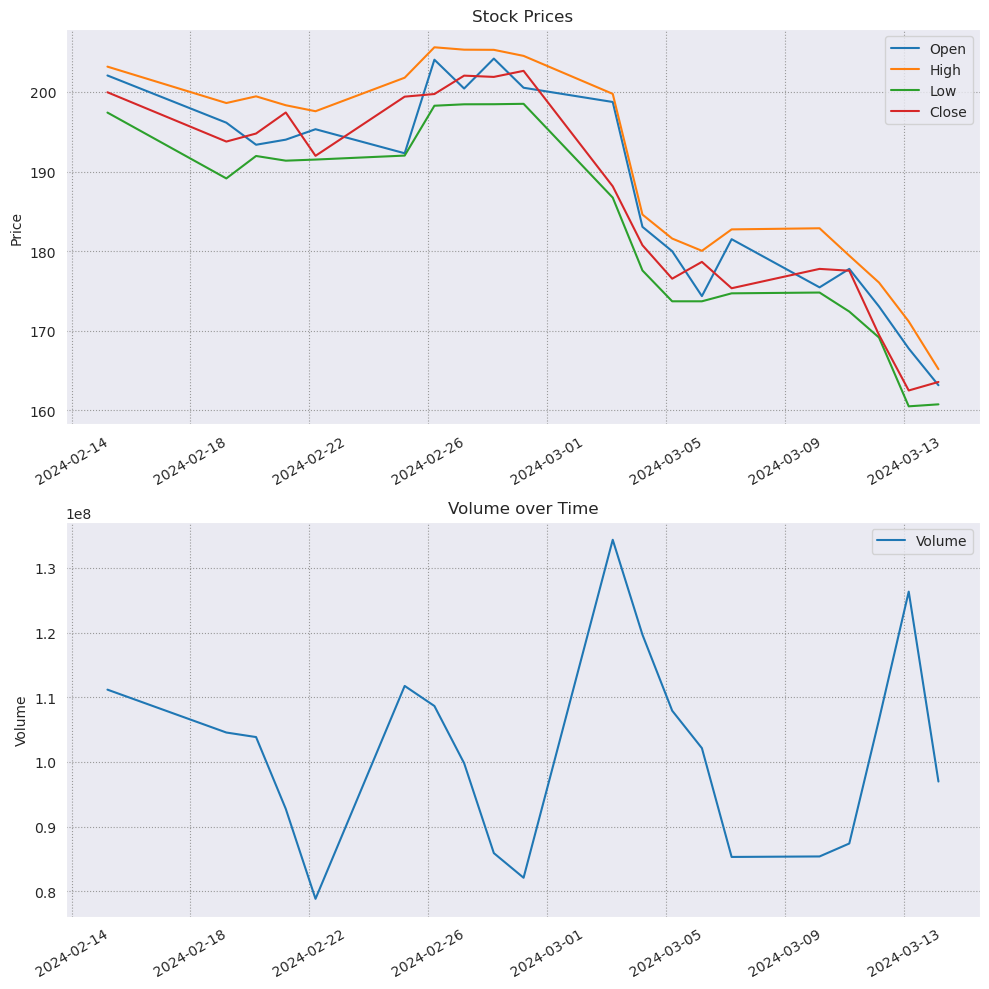

In [6]:
#Calling the defined function above
data_plot(tsla_data)

## Webscraping /extracting Tesla's revenue data

In [7]:
tesla_revenue = revenue_webscraper('https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue')
tesla_revenue.head()

,Date,Revenue
0,2023-12-31,25167.0
1,2023-09-30,23350.0
2,2023-06-30,24927.0
3,2023-03-31,23329.0
4,2022-12-31,24318.0


### Plot Tesla revenue graph

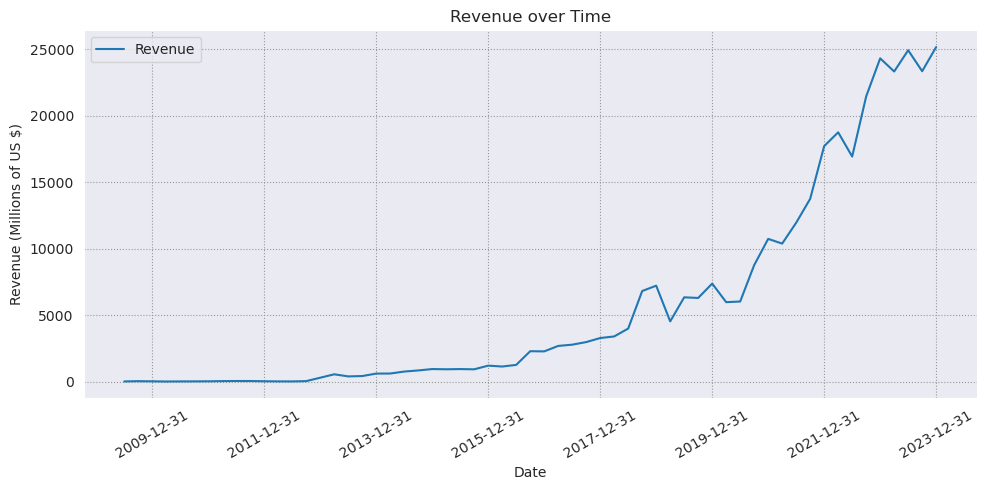

In [8]:
data_plot(tesla_revenue)

##  **GameStop**

### yfinance to extract stock data

In [9]:
# Instantiate a Ticker object for GameStop using the 'GME' ticker symbol
gamestop_data = yf.Ticker('GME')

# Retrieve historical stock data for GameStop using the 'history' method
gme_data = gamestop_data.history()

# Reset the index of the DataFrame to ensure proper data alignment
gme_data.reset_index(inplace=True)

# Display the first five rows of the DataFrame using head() function
gme_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2024-02-16 00:00:00-05:00,14.46,14.53,14.10,14.12,2297200,0.0,0.0
1,2024-02-20 00:00:00-05:00,13.96,14.05,13.16,13.49,3784500,0.0,0.0
2,2024-02-21 00:00:00-05:00,13.46,13.67,13.23,13.41,1731300,0.0,0.0
3,2024-02-22 00:00:00-05:00,13.50,13.65,13.34,13.36,1817800,0.0,0.0
4,2024-02-23 00:00:00-05:00,13.30,13.79,13.12,13.51,2319700,0.0,0.0


### Dashboard for GameStop's stock data

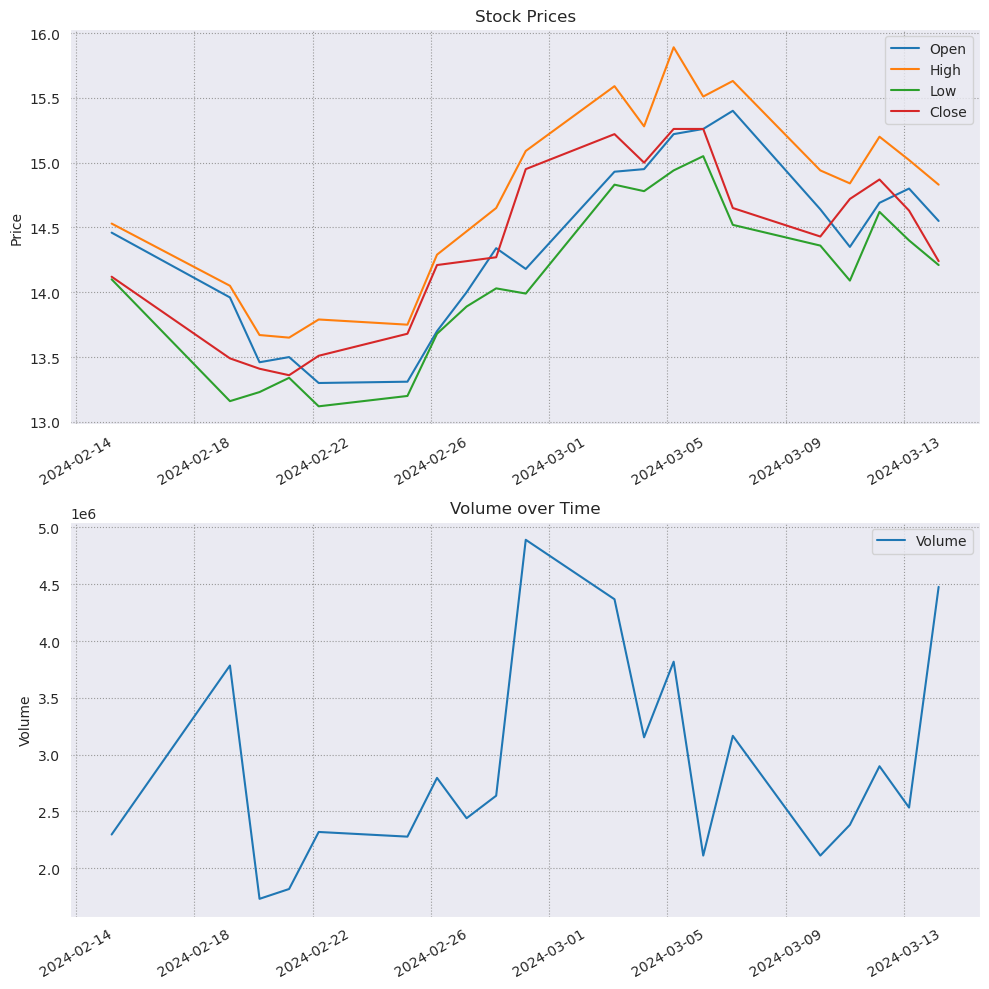

In [10]:
data_plot(gme_data)

### Webscraping /extracting GameStop's revenue data

In [11]:
gme_revenue = revenue_webscraper('https://www.macrotrends.net/stocks/charts/GME/gamestop/revenue')
gme_revenue.head()

,Date,Revenue
0,2023-10-31,1078
1,2023-07-31,1164
2,2023-04-30,1237
3,2023-01-31,2226
4,2022-10-31,1186


### Dashboard for GameStop's revenue data

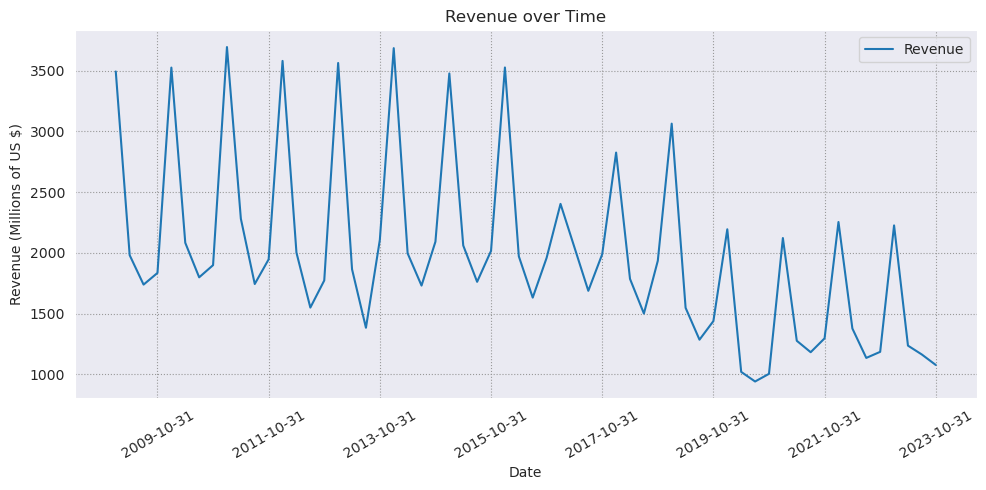

In [12]:
data_plot(gme_revenue)

## Author
Eybert Macedo